In [17]:
import scipy.io
from scipy import signal
from scipy import stats
import numpy as np
import pandas as pd
from hurst import compute_Hc
import random
import os
import time

import matplotlib.pyplot as plt
import seaborn as sn

# import keras
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
# from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
# from sklearn.metrics import precision_score
# from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
import tensorflow as tf

from imblearn.over_sampling import SMOTE

# Importation données (80 features)

# Data importation : ECG&EEG extraction 
# Doubt about ECG, Resp1 & Resp2 data, are they really that ?


Files = [r'SOP01',
         r'SOP02',
         r'SOP03',
         r'SOP04',
         r'SOP05',
         r'SOP06',
         r'SOP07',
         r'SOP08',
         r'SOP09',
         r'SOP10',
         r'SOP11',
         r'SOP12',
         r'SOP13',
         r'SOP14',
         r'SOP15',
         r'SOP16',
         r'SOP17',
         r'SOP18',
         r'SOP19',
         r'SOP20']

Files_QoE = ['SOP1',
             'SOP2',
             'SOP3',
             'SOP4',
             'SOP5',
             'SOP6',
             'SOP7',
             'SOP8',
             'SOP9',
             'SOP10',
             'SOP11',
             'SOP12',
             'SOP13',
             'SOP14',
             'SOP15',
             'SOP16',
             'SOP17',
             'SOP18',
             'SOP19',
             'SOP20']

def data_extraction(Files, Files_QoE):
    
    start_time = time.time()
    data_EEG = []
    ses = ['A','B','C']
    
    print("--- Extracting data ---")
    
    for k in Files: # nombre de sujets 
        data_EEG_sujet = []
        for i in range(3): # nombre de sessions
            data_EEG_session = []
            for j in range(9): # nombre de videos
                print("--- Loading ", k+'_'+ses[i]+'_'+str(j+1), " ---")
                path_data = r'/o'[0]+k+'_'+ses[i]+'_'+str(j+1)+'.csv'
                data_temp = pd.read_csv(r'../data_EEG/3seconds' + path_data)

#                 data_EEG_temp = []
                print('Verif EEG:', data_temp.shape)
                data_EEG_video = []
                for x1 in range(len(data_temp)):
                    ligne = data_temp.iloc[x1]
                    ligne_mod = []
                    for x2 in data_temp.columns[1:]:
                        ligne_mod += [ligne[x2]]
                    data_EEG_video += [ligne_mod]
                print("--- Loaded ---")
                data_EEG_session += [data_EEG_video]
            data_EEG_sujet += [data_EEG_session]
        data_EEG += [data_EEG_sujet]
    print("Should be 20 :",len(data_EEG))
    print("Should be 3 :",len(data_EEG[0]))
    print("Should be 9 :",len(data_EEG[0][0]))
    print("Should be 40 :", len(data_EEG[0][0][0]))
    print("Should be 80 :", len(data_EEG[0][0][0][0]))

#     print(len(data_impedance))
#     print(len(data_impedance[0]))
    
    print("--- Loading QoE ---")
    
    QoE = []
    for k in Files_QoE:
        data_QoE = pd.read_excel(r'../SubjectiveRatings/SubjectiveRatings.xlsx',sheet_name=k)
        # Colonnes : 'SOP' = Q1 ; # = Q2 ; 'Unnamed: 4' = Q3 ; 'Unnamed: 5' = Q4 ; 'Unnamed: 6' = Q5 
        answers = []
        answers_SA = []
        answers_SB = []
        answers_SC = []
        for i in range(9):
            answers_SA += [[data_QoE['SOP'][5+i],data_QoE[data_QoE.columns[3]][5+i],data_QoE['Unnamed: 4'][5+i],data_QoE['Unnamed: 5'][5+i],data_QoE['Unnamed: 6'][5+i]]]

        for i in range(9):
            answers_SB += [[data_QoE['SOP'][14+i],data_QoE[data_QoE.columns[3]][14+i],data_QoE['Unnamed: 4'][14+i],data_QoE['Unnamed: 5'][14+i],data_QoE['Unnamed: 6'][14+i]]]

        for i in range(9):
            answers_SC += [[data_QoE['SOP'][23+i],data_QoE[data_QoE.columns[3]][23+i],data_QoE['Unnamed: 4'][23+i],data_QoE['Unnamed: 5'][23+i],data_QoE['Unnamed: 6'][23+i]]]

        QoE += [[answers_SA,answers_SB,answers_SC]]
    # print(data_QoE.shape)

    print(len(QoE))
    print(len(QoE[0]))
    print(len(QoE[0][0]))
    print(len(QoE[0][0][0]))
    print("Loading done in %s s" %(time.time()-start_time))
    
    return (data_EEG, QoE)

EEG_features,QoE = data_extraction(Files,Files_QoE)

# format data : [sujets,session,video,frames,features]
# format features : [delta,theta,alpha,beta,gamma]
                      
def Ratio_calculation(ESD):
    ratios = []
    for k in range(len(ESD)): # par sujet
        subject = []
        for i in range(len(ESD[0])): # par session
            session = []
            for j in range(len(ESD[0][0])): # par video
                video = []
                for x1 in range(len(ESD[0][0][0])): # par frame
                    frame = []
                    for x2 in range(int(len(ESD[0][0][0][0])/10)): # par electrode
                        Delta = ESD[k][i][j][x1][x2*10]
                        Theta = ESD[k][i][j][x1][(x2*10)+1]
                        Alpha = ESD[k][i][j][x1][(x2*10)+2]
                        Beta = ESD[k][i][j][x1][(x2*10)+3]
                        Gamma = ESD[k][i][j][x1][(x2*10)+4]

                        ratio_DT = Delta/Theta
                        ratio_DA = Delta/Alpha
                        ratio_DB = Delta/Beta
                        ratio_DG = Delta/Gamma

                        ratio_TD = Theta/Delta
                        ratio_TA = Theta/Alpha
                        ratio_TB = Theta/Beta
                        ratio_TG = Theta/Gamma

                        ratio_AD = Alpha/Delta
                        ratio_AT = Alpha/Theta
                        ratio_AB = Alpha/Beta
                        ratio_AG = Alpha/Gamma

                        ratio_BD = Beta/Delta
                        ratio_BT = Beta/Theta
                        ratio_BA = Beta/Alpha
                        ratio_BG = Beta/Gamma

                        ratio_GD = Gamma/Delta
                        ratio_GT = Gamma/Theta
                        ratio_GA = Gamma/Alpha
                        ratio_GB = Gamma/Beta

                        frame += [ratio_DT,ratio_DA,ratio_DB,ratio_DG,
                                ratio_TD,ratio_TA,ratio_TB,ratio_TG,
                                ratio_AD,ratio_AT,ratio_AB,ratio_AG,
                                ratio_BD,ratio_BT,ratio_BA,ratio_BG,
                                ratio_GD,ratio_GT,ratio_GA,ratio_GB]
                    video += [frame]
                session += [video]
            subject += [session]
        ratios += [subject] 
                      
    print("Should be 20 :",len(ratios))
    print("Should be 3 :",len(ratios[0]))
    print("Should be 9 :",len(ratios[0][0]))
    print("Should be 40 :", len(ratios[0][0][0]))
    print("Should be 5120 :", len(ratios[0][0][0][0]))
                      
    return ratios
                      
# Ratio_features = Ratio_calculation(EEG_features)

# Fusion data

def MiseFormatEEG(EEG):
    data_all = []
    for k in range(len(EEG)):
        data_sujet = []
        for i in range(len(EEG[0])):
            data_session = []
            for j in range(len(EEG[0][0])):
                data_video = []
                for l in range(len(EEG[0][0][0])):
                    data_video += [EEG[k][i][j][l]]
                data_session += [data_video]
            data_sujet += [data_session]
        data_all += [data_sujet]

    print("Should be 20 : ",len(data_all)) # Sujet
    print("Should be 3 : ",len(data_all[0])) # Session
    print("Should be 9 : ",len(data_all[0][0])) # Videos
    print("Should be 40 : ",len(data_all[0][0][0])) # lignes EEG
    print("Should be 1280 : ",len(data_all[0][0][0][0])) # colonnes EEG
    
    return data_all

data_all = MiseFormatEEG(EEG_features)

#################

data = []
for k in range(len(data_all)):
    for i in range(len(data_all[0])):
        for j in range(len(data_all[0][0])):
            data += [data_all[k][i][j]]

print("Longueur (540):", len(data))
print("Lignes single data point (40)", len(data[0]))
print("Colonnes single data point (1280)", len(data[0][0]))

# print("TEST :", len(QoE)*len(QoE[0])*len(QoE[0][0]))
# 3-class classification
y = []
compt1 = 0
compt2 = 0
compt3 = 0
# print("TEST :", len(QoE)*len(QoE[0])*len(QoE[0][0]))
y = []
y2 = []
y3 = []
y4 = []
y5 = []
for k in range(len(QoE)):
    for i in range(len(QoE[0])):
        for j in range(len(QoE[0][0])):
            if (QoE[k][i][j][0] <= 3):
                y += [0] #[[1,0,0]]
                compt1 += 1
            elif (QoE[k][i][j][0] <= 6):
                y += [1] #[[0,1,0]]
                compt2 += 1
            else:
                y += [2] #[[0,0,1]]
                compt3 += 1
                
            if (QoE[k][i][j][1] <= 3):
                y2 += [0] #[[1,0,0]]
                compt1 += 1
            elif (QoE[k][i][j][1] <= 6):
                y2 += [1] #[[0,1,0]]
                compt2 += 1
            else:
                y2 += [2] #[[0,0,1]]
                compt3 += 1
            
            if (QoE[k][i][j][2] <= 3):
                y3 += [0] #[[1,0,0]]
                compt1 += 1
            elif (QoE[k][i][j][2] <= 6):
                y3 += [1] #[[0,1,0]]
                compt2 += 1
            else:
                y3 += [2] #[[0,0,1]]
                compt3 += 1
                
            if (QoE[k][i][j][3] <= 3):
                y4 += [0] #[[1,0,0]]
                compt1 += 1
            elif (QoE[k][i][j][3] <= 6):
                y4 += [1] #[[0,1,0]]
                compt2 += 1
            else:
                y4 += [2] #[[0,0,1]]
                compt3 += 1
                
            if (QoE[k][i][j][4] <= 3):
                y5 += [0] #[[1,0,0]]
                compt1 += 1
            elif (QoE[k][i][j][4] <= 6):
                y5 += [1] #[[0,1,0]]
                compt2 += 1
            else:
                y5 += [2] #[[0,0,1]]
                compt3 += 1
            
# print("Equilibre classes :",compt1,compt2,compt3)              
print("Longueur Labels :", len(y))

--- Extracting data ---
--- Loading  SOP01_A_1  ---
Verif EEG: (40, 81)
--- Loaded ---
--- Loading  SOP01_A_2  ---
Verif EEG: (40, 81)
--- Loaded ---
--- Loading  SOP01_A_3  ---
Verif EEG: (40, 81)
--- Loaded ---
--- Loading  SOP01_A_4  ---
Verif EEG: (40, 81)
--- Loaded ---
--- Loading  SOP01_A_5  ---
Verif EEG: (40, 81)
--- Loaded ---
--- Loading  SOP01_A_6  ---
Verif EEG: (40, 81)
--- Loaded ---
--- Loading  SOP01_A_7  ---
Verif EEG: (40, 81)
--- Loaded ---
--- Loading  SOP01_A_8  ---
Verif EEG: (40, 81)
--- Loaded ---
--- Loading  SOP01_A_9  ---
Verif EEG: (40, 81)
--- Loaded ---
--- Loading  SOP01_B_1  ---
Verif EEG: (40, 81)
--- Loaded ---
--- Loading  SOP01_B_2  ---
Verif EEG: (40, 81)
--- Loaded ---
--- Loading  SOP01_B_3  ---
Verif EEG: (40, 81)
--- Loaded ---
--- Loading  SOP01_B_4  ---
Verif EEG: (40, 81)
--- Loaded ---
--- Loading  SOP01_B_5  ---
Verif EEG: (40, 81)
--- Loaded ---
--- Loading  SOP01_B_6  ---
Verif EEG: (40, 81)
--- Loaded ---
--- Loading  SOP01_B_7  ---
Ver

Dimensions de X: (540, 40, 80)
Dimensions de y: (540,)
Occurences avant SMOTE: [ 57 225 258]
occurences_y_train_before_SMOTE:  [ 41 180 211]
occurences_y_test_before_SMOTE:  [16 45 47]
Occurences après SMOTE: [211 211 211]
Epoch 1/250
20/20 [==============================] - 2s 47ms/step - loss: 13.2237 - accuracy: 0.3870 - val_loss: 1.1711 - val_accuracy: 0.4352
Epoch 2/250
20/20 [==============================] - 1s 39ms/step - loss: 1.1111 - accuracy: 0.4755 - val_loss: 0.9880 - val_accuracy: 0.5278
Epoch 3/250
20/20 [==============================] - 1s 41ms/step - loss: 1.0202 - accuracy: 0.5245 - val_loss: 0.9649 - val_accuracy: 0.5926
Epoch 4/250
20/20 [==============================] - 1s 39ms/step - loss: 0.9497 - accuracy: 0.5592 - val_loss: 0.9966 - val_accuracy: 0.5463
Epoch 5/250
20/20 [==============================] - 1s 39ms/step - loss: 0.8891 - accuracy: 0.6319 - val_loss: 1.0233 - val_accuracy: 0.5185
Epoch 6/250
20/20 [==============================] - 1s 39ms/step 

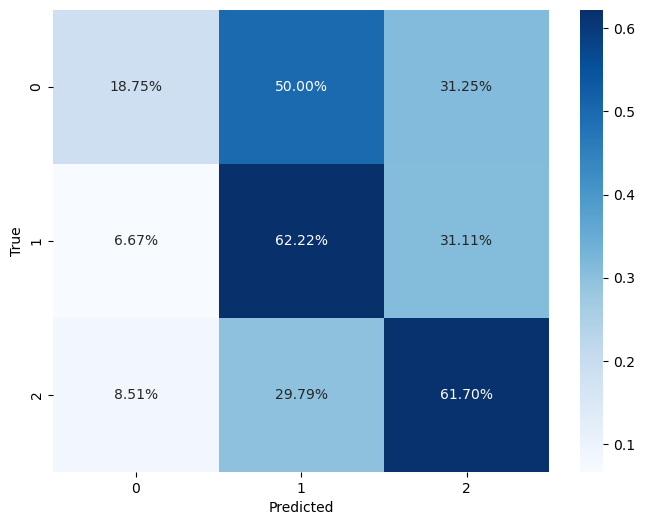

              precision    recall  f1-score   support

           0       0.30      0.19      0.23        16
           1       0.56      0.62      0.59        45
           2       0.60      0.62      0.61        47

    accuracy                           0.56       108
   macro avg       0.49      0.48      0.48       108
weighted avg       0.54      0.56      0.55       108



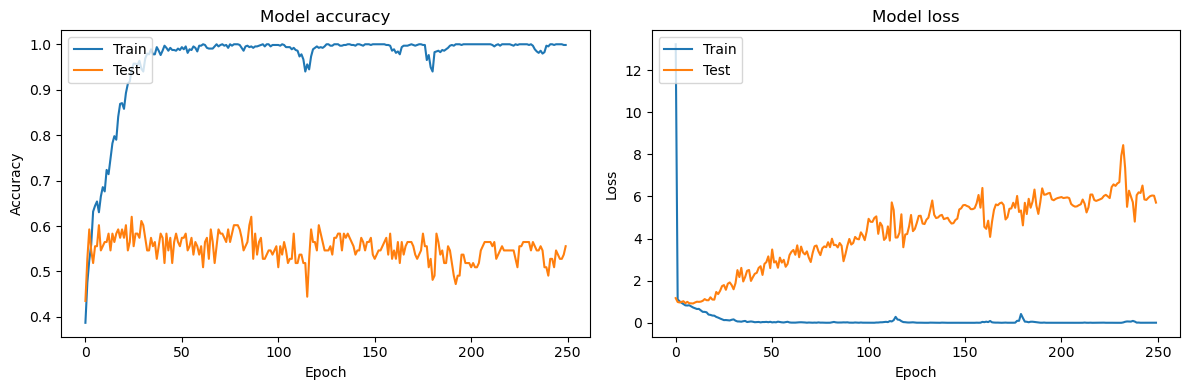

In [18]:
#Code classique

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE

# Convertir les listes en tableaux numpy pour les utiliser dans le modèle CNN
X = np.array(data)
y = np.array(y)

# Afficher les dimensions de vos données
print("Dimensions de X:", X.shape)
print("Dimensions de y:", y.shape)

# Ajouter une dimension de canal pour chaque exemple EEG
X = X.reshape(X.shape[0], 40, 80, 1)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Afficher le nombre d'occurrences de chaque classe avant SMOTE/Comprendre comment fonctionne le SMOTE sur chaque partie train et test
occurrences_before_smote = np.bincount(y)
occurences_y_train_before_SMOTE = np.bincount(y_train)
occurences_y_test_before_SMOTE = np.bincount(y_test)
print("Occurences avant SMOTE:", occurrences_before_smote)
print("occurences_y_train_before_SMOTE: ", occurences_y_train_before_SMOTE)
print("occurences_y_test_before_SMOTE: ", occurences_y_test_before_SMOTE)

# Appliquer SMOTE pour augmenter les données d'entraînement
#smote = SMOTE(random_state=42)
#X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(-1, 40 * 80), y_train)

borderline_smote = BorderlineSMOTE(random_state=42)
X_train_resampled, y_train_resampled = borderline_smote.fit_resample(X_train.reshape(-1, 40 * 80), y_train)

# Remettre les données dans la forme appropriée pour le modèle CNN
X_train_resampled = X_train_resampled.reshape(-1, 40, 80, 1)

# Afficher le nombre d'occurrences de chaque classe après SMOTE
occurrences_after_smote = np.bincount(y_train_resampled)
print("Occurences après SMOTE:", occurrences_after_smote)

# Définir le modèle CNN
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(40, 80, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# Compiler le modèle
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entraîner le modèle avec les données augmentées
history = model.fit(X_train_resampled, y_train_resampled, epochs=250, validation_data=(X_test, y_test), batch_size=32)

# Évaluer le modèle sur l'ensemble de test
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

# Prédire les classes sur l'ensemble de test
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Afficher la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_classes, normalize='true')
plt.figure(figsize=(8, 6))
sn.heatmap(conf_matrix, annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Afficher le rapport de classification
class_report = classification_report(y_test, y_pred_classes)
print(class_report)

# Afficher les courbes d'apprentissage
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()


In [8]:
#Code du CNN modifié pour avoir un split par sujet

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling3D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
# Définir le modèle CNN
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(9, 40, 80, 1)))  # Adjust input shape
model.add(MaxPooling3D(pool_size=(2, 2, 2)))  # Adjust pooling layer to 3D
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))  # Adjust pooling layer to 3D
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))  # Adjust pooling layer to 3D
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # Adjust output units to match the number of classes

# Compiler le modèle
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entraîner le modèle avec les données augmentées
history = model.fit(X_train_subjects, y_train_subjects, epochs=250, validation_data=(X_test_subjects, y_test_subjects), batch_size=32)

# Évaluer le modèle sur l'ensemble de test
loss, accuracy = model.evaluate(X_test_subjects, y_test_subjects)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

# Prédire les classes sur l'ensemble de test
y_pred = model.predict(X_test_subjects)
y_pred_classes = np.argmax(y_pred, axis=1)

# Afficher la matrice de confusion
conf_matrix = confusion_matrix(y_test_subjects, y_pred_classes, normalize='true')
plt.figure(figsize=(8, 6))
sn.heatmap(conf_matrix, annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Afficher le rapport de classification
class_report = classification_report(y_test_subjects, y_pred_classes)
print(class_report)

# Afficher les courbes d'apprentissage
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()



ValueError: Data cardinality is ambiguous:
  x sizes: 48
  y sizes: 16
Make sure all arrays contain the same number of samples.

In [13]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [20]:
#Code avec GridSearch 

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling3D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
import numpy as np
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

# Convertir les listes en tableaux numpy pour les utiliser dans le modèle CNN
X = np.array(data)
y = np.array(y)

# Afficher les dimensions de vos données
print("Dimensions de X:", X.shape)
print("Dimensions de y:", y.shape)

# Ajouter une dimension de canal pour chaque exemple EEG
X = X.reshape(X.shape[0], 40, 80, 1)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Afficher le nombre d'occurrences de chaque classe avant SMOTE/Comprendre comment fonctionne le SMOTE sur chaque partie train et test
occurrences_before_smote = np.bincount(y)
occurences_y_train_before_SMOTE = np.bincount(y_train)
occurences_y_test_before_SMOTE = np.bincount(y_test)
print("Occurences avant SMOTE:", occurrences_before_smote)
print("occurences_y_train_before_SMOTE: ", occurences_y_train_before_SMOTE)
print("occurences_y_test_before_SMOTE: ", occurences_y_test_before_SMOTE)

# Appliquer SMOTE pour augmenter les données d'entraînement
#smote = SMOTE(random_state=42)
#X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(-1, 40 * 80), y_train)

borderline_smote = BorderlineSMOTE(random_state=42)
X_train_resampled, y_train_resampled = borderline_smote.fit_resample(X_train.reshape(-1, 40 * 80), y_train)

# Remettre les données dans la forme appropriée pour le modèle CNN
X_train_resampled = X_train_resampled.reshape(-1, 40, 80, 1)

# Afficher le nombre d'occurrences de chaque classe après SMOTE
occurrences_after_smote = np.bincount(y_train_resampled)
print("Occurences après SMOTE:", occurrences_after_smote)

# Define the function to create the Keras model
def create_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(40, 80, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create KerasClassifier
model = KerasClassifier(build_fn=create_model, verbose=0)


# Define the parameter grid for GridSearch
param_grid = {
    'batch_size': [32, 64],
    'epochs': [100, 200, 300]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy')

# Fit the GridSearchCV object to the resampled training data
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best parameters and best score from the GridSearchCV
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Entraîner le modèle avec les données augmentées
#history = model.fit(X_train_resampled, y_train_resampled, epochs=250, validation_data=(X_test, y_test), batch_size=32)

# Évaluer le modèle sur l'ensemble de test
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

# Prédire les classes sur l'ensemble de test
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Afficher la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_classes, normalize='true')
plt.figure(figsize=(8, 6))
sn.heatmap(conf_matrix, annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Afficher le rapport de classification
class_report = classification_report(y_test, y_pred_classes)
print(class_report)

# Afficher les courbes d'apprentissage
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()


Dimensions de X: (540, 40, 80)
Dimensions de y: (540,)
Occurences avant SMOTE: [ 57 225 258]
occurences_y_train_before_SMOTE:  [ 41 180 211]
occurences_y_test_before_SMOTE:  [16 45 47]
Occurences après SMOTE: [211 211 211]


c:\Users\loris\anaconda3\envs\Projet_Final\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\loris\anaconda3\envs\Projet_Final\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\loris\anaconda3\envs\Projet_Final\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\loris\anaconda3\envs\Projet_Final\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error inste

Best Parameters: {'batch_size': 64, 'epochs': 100}
Best Score: 0.7235387045813586


AttributeError: 'KerasClassifier' object has no attribute 'evaluate'